In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
from Constants import *
from Sterile_Nu_Parameters import *
from Momentum_Grid import *
from Tolerances import *

from DOF import *
from System_SterileDM_Prod import System_SterileDM_Prod
from Make_Rate_Table import Make_Table
from Asy_Redistribution import eqs_redist
from Thermo_quantities import Thermo_quantities
#atol = 1e-12 rtol =1e-4 tol = 1e-12 n=3000

In [2]:
#Making table of the reaction rates

Gamma_a_Table = np.zeros((ni_Table,nT_Table)) #numbers of momentum and temperature grid
Gamma_a_anti_Table = np.zeros((ni_Table,nT_Table))

if (flavor == 'e'):

    La_ini = Le_ini
    
elif(flavor == 'mu'):
    
    La_ini = Lmu_ini
    
else:
    
    La_ini = Ltau_ini

Gamma_a_Table, Gamma_a_anti_Table = Make_Table(La_ini)

In [ ]:
#initial conditions of Density matrix and photon temperature
#x: comoving time ,y: comoving momentum

import time

start = time.time()

n_ms = 16
n_Uas = 31

Omega_nus = np.zeros([n_Uas,n_ms])
ms_Table = np.zeros(n_ms)
Uas_Table = np.zeros(n_Uas)

f_nus_0 = np.zeros(n)
f_nus_anti_0 = np.zeros(n)

for nn_ms in range(n_ms):
    
    
    ms = 10**(0.5+0.1*nn_ms)*1e-3 #keV->MeV
    ms_Table[nn_ms] = 10**(0.5+0.1*nn_ms) #keV
    
    Omega_nus_tmp = 0
    
    
    for nn_Uas in range(n_Uas):
        
        Uas = 10**(-(8-0.1*nn_Uas))
        Uas_Table[nn_Uas] = 10**(-(8-0.1*nn_Uas)*2) #squared
        
        if (Omega_nus_tmp > 1.4):
            
            Omega_nus[nn_Uas,nn_ms] = 2
            
        else:
            
            
            if (Uas <= (10**(-3/1.5*(np.log10(ms)+2.5)-13))**(1/2)): 
                
                Omega_nus[nn_Uas,nn_ms] = 0
                
            elif (ms < 0.004) and (Uas <= 10**(-6)):
                
                Omega_nus[nn_Uas,nn_ms] = 0
                
                
            else:

                T0 = 1e4 #MeV

                La_0 = np.zeros(1)

                if (flavor == 'e'):

                    La_0[0] = Le_ini
                    La_ini = Le_ini

                elif(flavor == 'mu'):

                    La_0[0] = Lmu_ini
                    La_ini = Lmu_ini


                else:

                    La_0[0] = Ltau_ini
                    La_ini = Ltau_ini



                x0 = np.array([0,0,0,0,0])

                ans0 =  sp.optimize.root(eqs_redist, x0, args = (T0,La_ini), method='hybr',tol=tol_root)  

                zeta_nue0 = ans0.x[0]
                zeta_numu0 = ans0.x[1]
                zeta_nutau0 = ans0.x[2]

                zeta_e0 = ans0.x[0] - ans0.x[4]
                zeta_mu0 = ans0.x[1] - ans0.x[4]
                zeta_tau0 = ans0.x[2] - ans0.x[4]

                zeta_B0 = ans0.x[3]

                zeta_Q0 = ans0.x[4]

                rho0, s0, P0, Delta_rho0, rho_nua0, rho_a0, Del_nua0, Del_a0, Del_nu_total0, Del_c_total0, Del_Q_QCD0 \
                          = Thermo_quantities(T0,zeta_nue0,zeta_numu0,zeta_nutau0,zeta_B0,zeta_Q0)

                s_ini = s0

                sys_values_0 = np.concatenate((f_nus_0,f_nus_anti_0,La_0))

                T_span = [1e4,3e1] 

                #T_eval = np.linspace(1e4,3e1,100)
                T_eval = [3e1]

                argList = [Gamma_a_Table,Gamma_a_anti_Table,s0,ms,Uas]


                #RK45 or LSODA might be better. #BDF might be better #atolの方が重要
                sol = solve_ivp(System_SterileDM_Prod,T_span,sys_values_0,t_eval=T_eval,args=argList,method='LSODA',atol=atol_ivp,rtol=rtol_ivp)

                l = len(sol.t)

                x0 = np.array([0,0,0,0,0])

                Tfin = 3e1
                Lfin = sol.y[2*n,l-1]

                ans =  sp.optimize.root(eqs_redist, x0, args = (Tfin,Lfin), method='hybr',tol=tol_root)  

                zeta_nue = ans.x[0]
                zeta_numu = ans.x[1]
                zeta_nutau = ans.x[2]

                zeta_e = ans.x[0] - ans.x[4]
                zeta_mu = ans.x[1] - ans.x[4]
                zeta_tau = ans.x[2] - ans.x[4]

                zeta_B = ans.x[3]

                zeta_Q = ans.x[4]

                rho_fin, s_fin, P_fin, Delta_rho_fin, rho_nua_fin, rho_a_fin, Del_nua_fin, Del_a_fin, Del_nu_total_fin, Del_c_total_fin, Del_Q_QCD_fin \
                          = Thermo_quantities(Tfin,zeta_nue,zeta_numu,zeta_nutau,zeta_B,zeta_Q)

                #DM abundance

                l = len(sol.t)

                n_nus = 0

                for ni in range(n):

                    #y = y_min*10**(delta*ni)
                    #dy = y_min*10**(delta*ni) - y_min*10**(delta*(ni-1)) #あってる?

                    #dy = (y_max-y_min)/(n-1)
                    #y = y_min + dy*ni

                    y = y2[ni]
                    dy = dy2[ni]

                    n_nus += dy*y**2*(sol.y[ni,l-1] + sol.y[ni+n,l-1])

                n_nus *= 1/(2*np.pi**2)*(s_fin/s_ini)

                T = sol.t[l-1]

                gs = gs_below120MeV(T)

                gs_0 = gs_below120MeV(1e-2)

                s_0 = 2*np.pi**2/45*gs_0

                T0 = 2.73/11600*1e-6 #K->eV->MeV

                h=0.673

                rho_cr0 = 1.878*1e-29*h**2 #g cm^-3

                rho_cr0 *= (0.511*3.862*1e-11)**3 # g cm^-3 -> g MeV^3
                rho_cr0 *= 0.511/9.109*1e28 #g MeV^3->MeV^4

                Omega_nus[nn_Uas,nn_ms] = ms*T0**3*(s_0/s_fin)/rho_cr0*n_nus*1/0.26
                Omega_nus_tmp = ms*T0**3*(s_0/s_fin)/rho_cr0*n_nus*1/0.26
                
                print(Uas_Table[nn_Uas])
                print(ms_Table[nn_ms])
                print(Omega_nus[nn_Uas,nn_ms])
                
end = time.time()

time_diff = end - start

1.584893192461111e-12
3.1622776601683795
0.11732020670824646
2.5118864315095823e-12
3.1622776601683795
0.147678540748073
3.981071705534986e-12
3.1622776601683795
0.18586667948777533
6.309573444801943e-12
3.1622776601683795
0.23389945254233402
1e-11
3.1622776601683795
0.2943036085964094
1.5848931924611107e-11
3.1622776601683795
0.370245796502385
2.5118864315095823e-11
3.1622776601683795
0.4656901737960234
3.9810717055349857e-11
3.1622776601683795
0.5855995246734985
6.309573444801942e-11
3.1622776601683795
0.7362843625840825
1e-10
3.1622776601683795
0.9324064835187859
1.584893192461111e-12
3.9810717055349722
0.33184860831814633
2.5118864315095823e-12
3.9810717055349722
0.41770569532962487
3.981071705534986e-12
3.9810717055349722
0.525720839158956
6.309573444801943e-12
3.9810717055349722
0.6617156366782672
1e-11
3.9810717055349722
0.8364576058933854
1.5848931924611107e-11
3.9810717055349722
1.0523546585390076
2.5118864315095823e-11
3.9810717055349722
1.330005175272385
3.9810717055349857e-

In [ ]:
print(time_diff)

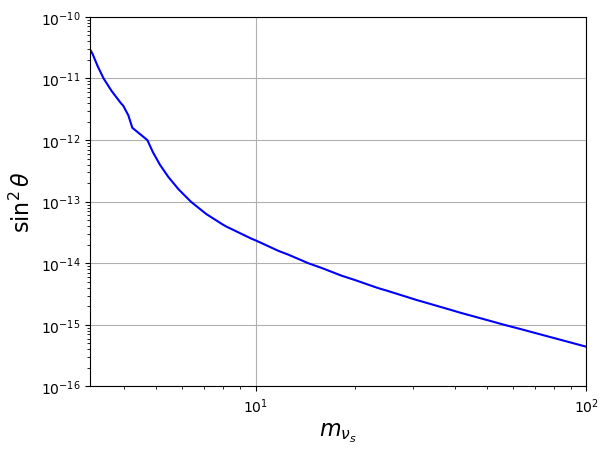

In [9]:
# 等高線図の生成。
cont=plt.contour(ms_Table,Uas_Table,Omega_nus,levels=[1],colors=['blue'])
#cont.clabel(fmt='%1.0f', fontsize=14)


#pp=plt.colorbar (orientation="vertical") # カラーバーの表示 
#pp.set_label("Label", fontname="Arial", fontsize=24) #カラーバーのラベル

plt.xlabel(r'$m_{\nu_s}$', fontsize=16)
plt.ylabel(r'$\sin^2\theta$', fontsize=16)

plt.ylim([1e-16, 1e-10])
plt.yscale('log')
plt.xscale('log')

plt.grid()
plt.show()

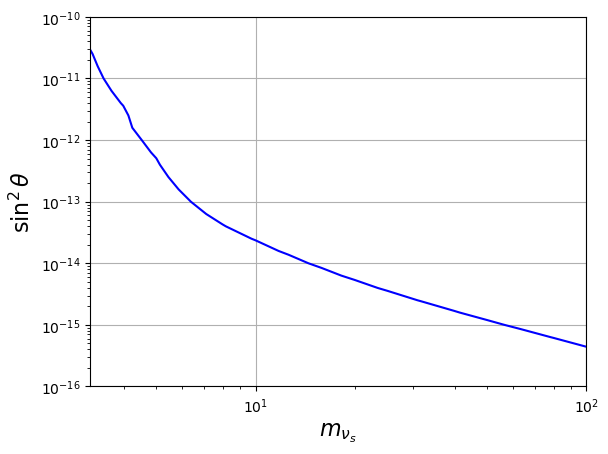

In [23]:
# 等高線図の生成。
cont=plt.contour(ms_Table,Uas_Table,Omega_nus,levels=[1],colors=['blue'])
#cont.clabel(fmt='%1.0f', fontsize=14)


#pp=plt.colorbar (orientation="vertical") # カラーバーの表示 
#pp.set_label("Label", fontname="Arial", fontsize=24) #カラーバーのラベル

plt.xlabel(r'$m_{\nu_s}$', fontsize=16)
plt.ylabel(r'$\sin^2\theta$', fontsize=16)

plt.ylim([1e-16, 1e-10])
plt.yscale('log')
plt.xscale('log')

plt.grid()
plt.show()

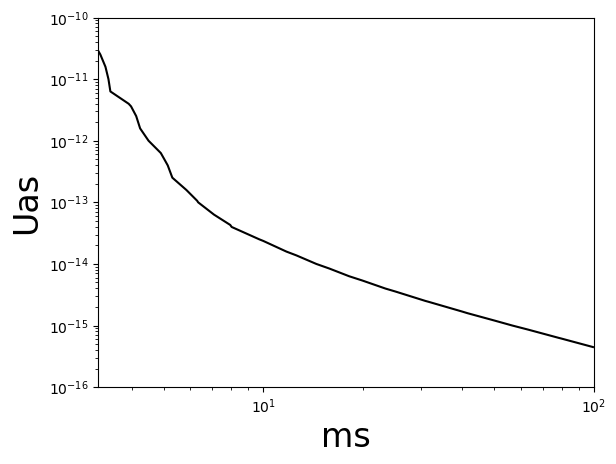

In [10]:
# 等高線図の生成。
cont=plt.contour(ms_Table,Uas_Table,Omega_nus,levels=[1],colors=['black'])
#cont.clabel(fmt='%1.0f', fontsize=14)


#pp=plt.colorbar (orientation="vertical") # カラーバーの表示 
#pp.set_label("Label", fontname="Arial", fontsize=24) #カラーバーのラベル

plt.xlabel('ms', fontsize=24)
plt.ylabel('Uas', fontsize=24)

plt.ylim([1e-16, 1e-10])
plt.yscale('log')
plt.xscale('log')


plt.show()

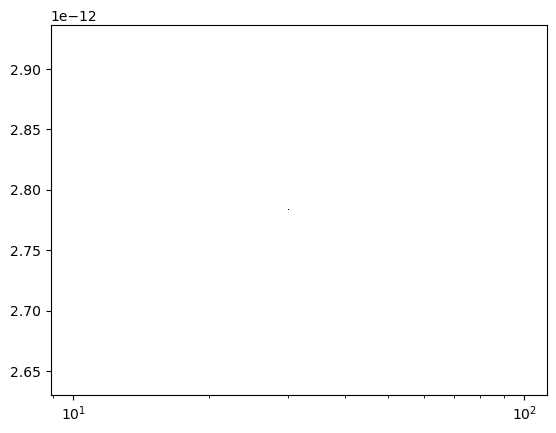

In [14]:
#Evolution of neutrino spectra with a fixed momentum
plt.semilogx(sol.t,sol.y[n+20,:],'k,-')
plt.show()

In [18]:
print(len(sol.t))

1
1


In [6]:
l=len(sol.t)

sol.t[l-1]

30.0

In [14]:
x0 = np.array([0,0,0,0,0])

T0 = 1e4 #MeV

ans0 =  sp.optimize.root(eqs_redist, x0, args = (T0,La_ini), method='hybr',tol=tol_root)  

zeta_nue0 = ans0.x[0]
zeta_numu0 = ans0.x[1]
zeta_nutau0 = ans0.x[2]

zeta_e0 = ans0.x[0] - ans0.x[4]
zeta_mu0 = ans0.x[1] - ans0.x[4]
zeta_tau0 = ans0.x[2] - ans0.x[4]

zeta_B0 = ans0.x[3]

zeta_Q0 = ans0.x[4]

rho0, s0, P0, Delta_rho0, rho_nua0, rho_a0, Del_nua0, Del_a0, Del_nu_total0, Del_c_total0, Del_Q_QCD0 \
          = Thermo_quantities(T0,zeta_nue0,zeta_numu0,zeta_nutau0,zeta_B0,zeta_Q0)
s_ini = s0

x0 = np.array([0,0,0,0,0])

Tfin = 3e1
Lfin = sol.y[2*n,l-1]

ans =  sp.optimize.root(eqs_redist, x0, args = (Tfin,Lfin), method='hybr',tol=tol_root)  

zeta_nue = ans.x[0]
zeta_numu = ans.x[1]
zeta_nutau = ans.x[2]

zeta_e = ans.x[0] - ans.x[4]
zeta_mu = ans.x[1] - ans.x[4]
zeta_tau = ans.x[2] - ans.x[4]

zeta_B = ans.x[3]

zeta_Q = ans.x[4]

rho_fin, s_fin, P_fin, Delta_rho_fin, rho_nua_fin, rho_a_fin, Del_nua_fin, Del_a_fin, Del_nu_total_fin, Del_c_total_fin, Del_Q_QCD_fin \
          = Thermo_quantities(Tfin,zeta_nue,zeta_numu,zeta_nutau,zeta_B,zeta_Q)

#rho_fin, s_fin, P_fin, Delta_rhofin = Thermo_quantities(Tfin,zeta_nue,zeta_numu,zeta_nutau,zeta_B,zeta_Q)

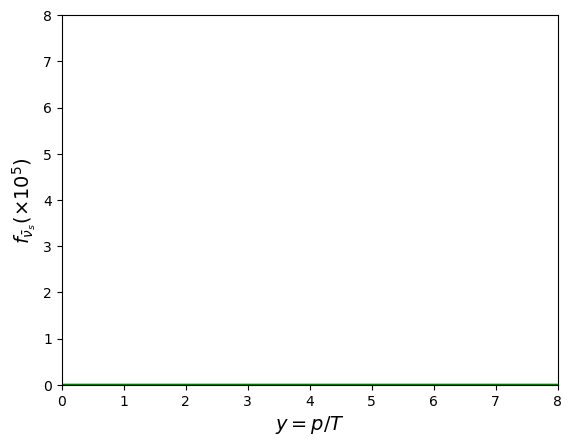

In [15]:
l = len(sol.t)
yy = np.zeros(n)
fs = np.zeros(n)

for ni in range(n):
    
    #yy[ni] = y_min*10**(delta*ni)
    #dy = y_min*10**(delta*ni+1) - y_min*10**(delta*ni) #あってる?
    
    #grho_fin, gs_fin, dgrhodT_fin = DOF(1e1)

    #grho_ini, gs_ini, dgrhodT_ini = DOF(1e4)
    
    yy[ni] = (s_fin/s_ini)**(1/3)*y2[ni] 
    fs[ni] = (s_fin/s_ini)**(2/3)*y2[ni]**2*sol.y[n+ni,l-1]*1e5

plt.plot(yy,fs,'g,-')
plt.xlim([0, 8])
plt.ylim([0, 8])
plt.xlabel(r'$y=p/T$',fontsize=14)
plt.ylabel(r'$f_{\bar{\nu}_s}(\times 10^5)$',fontsize=14)
plt.show()

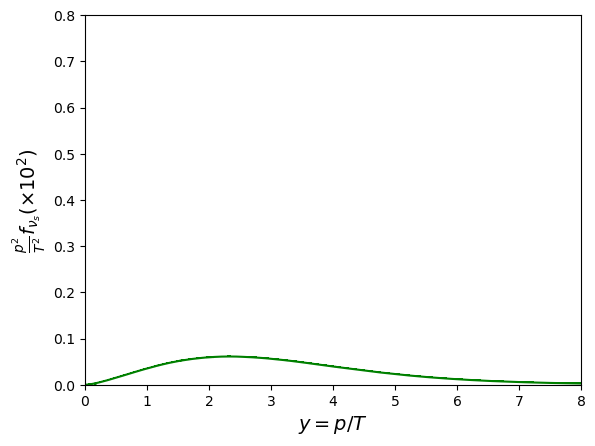

In [16]:
l = len(sol.t)
yy = np.zeros(n)
fs = np.zeros(n)

for ni in range(n):
    #yy[ni] = y_min*10**(delta*ni)
    #dy = y_min*10**(delta*ni+1) - y_min*10**(delta*ni) #あってる?
    
    yy[ni] = (s_fin/s_ini)**(1/3)*y2[ni] 
    fs[ni] = (s_fin/s_ini)**(2/3)*y2[ni]**2*sol.y[ni,l-1]*1e2

plt.plot(yy,fs,'g,-')
plt.xlim([0, 8])
plt.ylim([0, 0.8])
plt.xlabel(r'$y=p/T$',fontsize=14)
plt.ylabel(r'$\frac{p^2}{T^2}f_{\nu_s}(\times 10^2)$',fontsize=14)
plt.show()

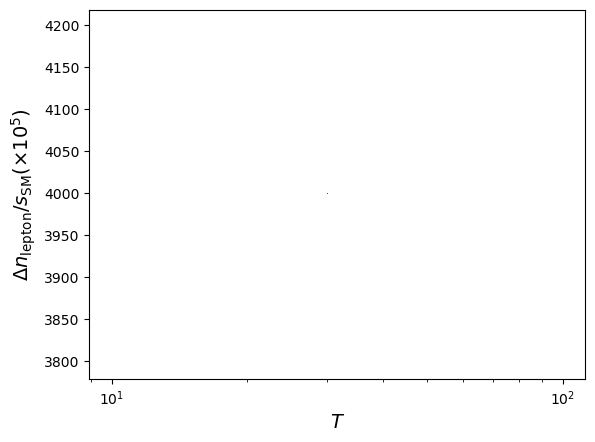

In [17]:
#Evolution of asymmetry with a fixed momentum
l = len(sol.t)
LL = np.zeros(l)

for nt in range(l):
    
    L_tmp = sol.y[2*n,nt]
    
    
    LL[nt] = L_tmp*1e5
    



plt.semilogx(sol.t,LL,'g,-')
#plt.xlim([1e2, 2e2])
#plt.ylim([1, 3])
plt.xlabel(r'$T$',fontsize=14)
plt.ylabel(r'$\Delta n_{\rm lepton}/s_{\rm SM}(\times 10^5)$',fontsize=14)
plt.show()

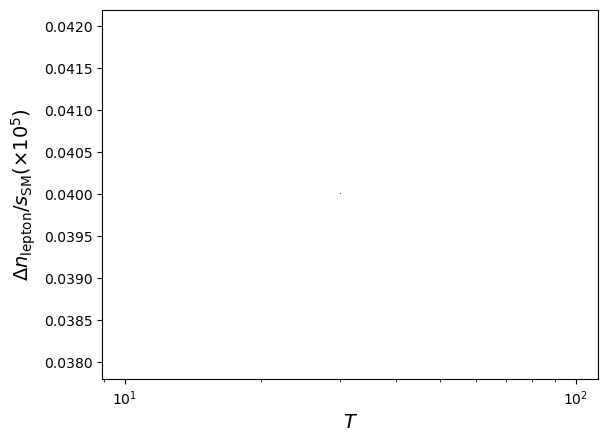

In [18]:
#Evolution of asymmetry with a fixed momentum
l = len(sol.t)
LL = np.zeros(l)
n_nus = np.zeros(l)


for nt in range(l):
    
    L_tmp = sol.y[2*n,nt]
    
    
    LL[nt] = L_tmp
    
    for ni in range(n):
    
        y = y2[ni]
        dy = dy2[ni]
        
        n_nus[nt] += dy*y**2*(sol.y[ni,nt] - sol.y[ni+n,nt])
            
    n_nus[nt] *= 1/s_ini*1/(2*np.pi**2)
    
    
    LL[nt] += n_nus[nt]
    



plt.semilogx(sol.t,LL,'g,-')
#plt.xlim([1e2, 2e2])
#plt.ylim([7, 10])
plt.xlabel(r'$T$',fontsize=14)
plt.ylabel(r'$\Delta n_{\rm lepton}/s_{\rm SM}(\times 10^5)$',fontsize=14)
plt.show()

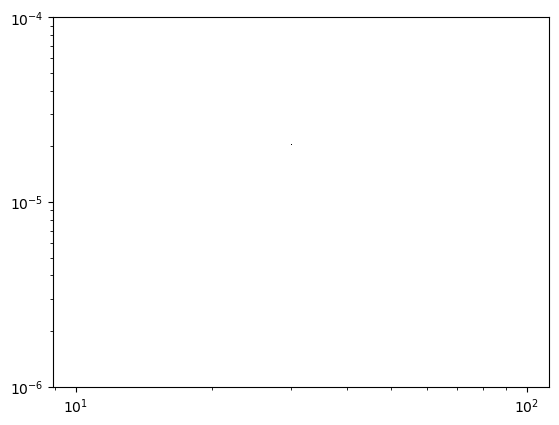

In [19]:
#Evolution of abundance of sterile nu
l = len(sol.t)
n_nus = np.zeros(l)


for nt in range(l):

    
    for ni in range(n):
        
        y = y2[ni]
        dy = dy2[ni]
        
        n_nus[nt] += dy*y**2*(sol.y[ni,nt] + sol.y[ni+n,nt])
        
    n_nus[nt] *= 1/s_ini*1/(2*np.pi**2)
    


plt.plot(sol.t,n_nus,'k,-')
#plt.plot(sol.y[2*n+1,:],n_nus,'k,-',linestyle='None')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e2, 1e3])
plt.ylim([1e-6, 1e-4])
plt.show()

In [20]:
#DM abundance

l = len(sol.t)

n_nus = 0

for ni in range(n):
    
    #y = y_min*10**(delta*ni)
    #dy = y_min*10**(delta*ni) - y_min*10**(delta*(ni-1)) #あってる?
    
    #dy = (y_max-y_min)/(n-1)
    #y = y_min + dy*ni
    
    y = y2[ni]
    dy = dy2[ni]
    
    n_nus += dy*y**2*(sol.y[ni,l-1] + sol.y[ni+n,l-1])
    
n_nus *= 1/(2*np.pi**2)*(s_fin/s_ini)

T = sol.t[l-1]

gs = gs_below120MeV(T)

gs_0 = gs_below120MeV(1e-2)

s_0 = 2*np.pi**2/45*gs_0

T0 = 2.73/11600*1e-6 #K->eV->MeV

h=0.673

rho_cr0 = 1.878*1e-29*h**2 #g cm^-3

rho_cr0 *= (0.511*3.862*1e-11)**3 # g cm^-3 -> g MeV^3
rho_cr0 *= 0.511/9.109*1e28 #g MeV^3->MeV^4

Omega_nus = ms*T0**3*(s_0/s_fin)/rho_cr0*n_nus


print(Omega_nus)

0.24825047512946108


In [17]:
#n=200 0.733

In [12]:
f_nus = np.ones(1)
f_nus_anti = np.ones(1)

rho_nus_tmp = dy2*y2**2*(y2**2 + ms**2)**(1/2)*(f_nus + f_nus_anti)

rho_nus =  1/(2*np.pi**2)*sp.integrate.trapz(dy2*y2**2*(y2**2 + ms**2)**(1/2)*(f_nus + f_nus_anti))

In [15]:
print(y2[99])

20.0
